# A Comparison of Machine Learning and Deep Learning Techniques for Activity Recognition using Mobile Devices
### A. Baldominos, Y. Saez and P. Isasi (*Universidad Carlos III de Madrid*)

This Python notebook contains the code for the paper submitted to the Special Issue on Intelligent Applications for Mobile Health of the Journal of Mobile Information Systems.

In this paper, we have used the dataset for mobile activity recognition provided by Shoaib et al. [1] and compared different classical machine learning and deep learning techniques for evaluating their performance.

[1] Shoaib, M., Bosch, S., Incel, O. D., Scholten, H., & Havinga, P. J. (2016). **Complex human activity recognition using smartphone and wrist-worn motion sensors**. *Sensors*, 16(4), 426.

In [6]:
import pandas as pd
import numpy as np
from IPython.display import set_matplotlib_formats
import sliding_window as sw
from scipy import stats as st
import sklearn.ensemble
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.neural_network
import sklearn.metrics
import time
import warnings
from __future__ import print_function
warnings.filterwarnings("ignore")

TRAIN_TEST_SPLIT = 0.7
RSEEDS = [93797449, 81918009, 61132739, 37701167, 78112324, 25567961, 22644213, 74540349, 98054267, 71167868, 16252189, 1813579, 39363446, 855513, 74041245, 22950172, 18426920, 34295891, 86828940, 62062274]

### Loading data
First, we will load the raw data. Data is stored in two different files, one per each dataset (pocket and wrist). We will load both and remove the timestamp, as it is useless for classification (even worst, it could potentially introduce undesired biases!).

Data will be load as Pandas dataframes in order to enable easy manipulation.

In [2]:
datasets_names = ['smartphoneatpocket', 'smartphoneatwrist']
cols = ['ts', 'accx', 'accy', 'accz', 'laccx', 'laccy', 'laccz', 'gyrx', 'gyry', 'gyrz', 'magx', 'magy', 'magz', 'activity']
usec  = set(cols) - set(['ts'])
acts = {
    11111 : 'walk', 11112 : 'stand', 11113 : 'jog', 11114 : 'sit', 11115 : 'bike', 
    11116 : 'upstairs', 11117 : 'downstairs', 11118 : 'type', 11119 : 'write', 11120 : 'coffee',
    11121 : 'talk', 11122 : 'smoke', 11123 : 'eat'
}

raw_datasets = {}
for dn in datasets_names:
    raw_datasets[dn] = pd.read_csv('data/{}.csv'.format(dn), names=cols, usecols=usec)

### Grouping by activity
In the next stages, we will require to manipulate instances of each activity separately. Now, we will proceed to separate data for each activity. Eventually, we will mix them up again after transformation and before classification.

In [3]:
grouped_datasets = {}
for (name, data) in raw_datasets.items():
    data = data.groupby('activity')
    grouped_datasets[name] = data

### Visualizing raw data
Before proceeding, we can stop for a minute and visualize some raw data. This can lead to very useful interpretations. For example, now we will plot 10 seconds of data for the walking, jogging and smoking activities, both for the pocket and the wrist. 

This can be useful to better understand what is going on. For example, we can see how, from the pocket, jogging and walking are similar, thus the latter has a smaller frequency. However, the hand movement in those activities is quite different.

In [ ]:
%pylab inline
set_matplotlib_formats('pdf', 'svg')
pylab.rcParams['figure.figsize'] = (12, 3)

sources = ['pocket', 'wrist']
for source in sources:
    for (code, group) in grouped_datasets['smartphoneat{}'.format(source)]:
        if acts[code] in ['walk', 'jog', 'smoke']:
            acc = group[['accx', 'accy', 'accz']][:501] # 10 seconds
            ax = acc.plot(x=np.arange(0,10.01,0.02), legend=False)
            ax.set_title('{} ({})'.format(acts[code], source))
            #ax.get_figure().savefig('{}_{}.eps'.format(acts[code], source))

### Segmenting data
Now, we can segment data by using a sliding window of a given size and step as described in the paper. Since data is sampled at 50 Hz, then a window size of 50 would correspond to 1 second of data. 

In [ ]:
SLIDING_WINDOW_SIZE = 3000
SLIDING_WINDOW_STEP = 1500

sliding_datasets = {}
for (name, groups) in grouped_datasets.items():
    sliding_datasets[name] = {}
    for (act, group) in groups:
        group = group.drop('activity', axis='columns')
        windows = sw.sliding_window(group.values, (SLIDING_WINDOW_SIZE,1), 
                                    ss=(SLIDING_WINDOW_STEP,1), flatten=False).reshape(-1, len(usec)-1, SLIDING_WINDOW_SIZE)
        sliding_datasets[name][act] = windows

### Computing the DFT of raw data

Now, we will compute the Discrete Fourier Transform of the raw data. The transformed waveform will be used in the feature extraction stage.

In [ ]:
fft_datasets = {}
for (name, data) in sliding_datasets.items():
    fft_datasets[name] = {}
    for (act, windows) in data.items():
        windows_fft = np.fft.fft(windows)
        fft_datasets[name][act] = (windows, windows_fft.real, windows_fft.imag)

### Extracting features and building the final ML dataset
Now, we will extract features, that will consist in certain statistical values extracted from both the raw data and the FFT transformed signal. These features are:

- The mean of the raw signal
- The standard dev. of the raw signal
- The median of the transformed signal
- The interquartiles (Q1 and Q3) of the transformed signal
- The skewness of the transformed signal
- The kurtosis of the transformed signal

After computing these features, a 70% of the data for each activity is left for training and the remaining 30% is reserved for testing. Since data is not shuffled, the test set always refers to data located in the future with respect to the training set.

Finally, data from all the activities are grouped together again, after separating them for train and test. Therefore, we are guaranteeing that the train set and the test set have the same amount of data for each activity.

In [ ]:
final_datasets = {}
for (name, data) in fft_datasets.items():
    subsets = []
    for (act, (raw, fftr, ffti)) in data.items():
        ap = np.stack([
                np.mean(raw, axis=-1),
                np.median(fftr, axis=-1), 
                np.std(raw, axis=-1), 
                np.percentile(fftr, 25, axis=-1), 
                np.percentile(fftr, 75, axis=-1),
                st.skew(fftr, axis=-1), 
                st.kurtosis(fftr, axis=-1)
            ], axis=-1)
        subsets.append(ap.reshape(-1, ap.shape[-2] * ap.shape[-1]))
    final_datasets[name] = np.concatenate(subsets)
    
    X_train = np.concatenate([subset[:int(len(subset) * TRAIN_TEST_SPLIT)] for subset in subsets])
    X_test  = np.concatenate([subset[int(len(subset) * TRAIN_TEST_SPLIT):] for subset in subsets])
    y_train = np.concatenate([[data.keys()[i]] * int(len(subsets[i]) * TRAIN_TEST_SPLIT) for i in range(len(data))])
    y_test  = np.concatenate([[data.keys()[i]] * (len(subsets[i]) - int(len(subsets[i]) * (TRAIN_TEST_SPLIT))) for i in range(len(data))])
    final_datasets[name] = (X_train, y_train, X_test, y_test)
    
final_datasets['smartphoneatboth'] = (
    np.concatenate([final_datasets['smartphoneatwrist'][0], final_datasets['smartphoneatpocket'][0]], axis=-1),
    final_datasets['smartphoneatwrist'][1],
    np.concatenate([final_datasets['smartphoneatwrist'][2], final_datasets['smartphoneatpocket'][2]], axis=-1),
    final_datasets['smartphoneatwrist'][3]
)

### Normalizing the data
Additionally, we will normalize the data in order to obtain a new dataset with 0-mean and unitary variance. To achieve so, we will substract the mean of the training set from the data and divide it by the variance.

In [ ]:
final_datasets_norm = {}
for (name, data) in final_datasets.items():
    X_train, y_train, X_test, y_test = data
    mean = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis=0)
    final_datasets_norm[name] = (
        (X_train - mean) / sigma,
        y_train,
        (X_test - mean) / sigma,
        y_test
    )

### Training and evaluating the classifiers
Then, we will train and evaluate the different classifiers. Since some of them are stochastic, we will use 20 randomly generating seeds. This reduces the bias, but since the seeds are provided, results are easily reproducible. In the case of deterministic classifiers, they will have zero-variance.

Results will be stored in a CSV file, that can be processed in a later stage for their interpretation.

In [ ]:
clfs = [
    sklearn.linear_model.LogisticRegression(),
    sklearn.ensemble.RandomForestClassifier(n_estimators=20, max_depth=30),
    sklearn.ensemble.ExtraTreesClassifier(n_estimators=20, max_depth=30),
    sklearn.naive_bayes.GaussianNB(),
    sklearn.neighbors.KNeighborsClassifier(n_neighbors=5),
    sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(200,100), max_iter=2000)
]

norms = [True, False]
results = open('results/classicalml.txt', 'w')
print('{},{},{},{},{},{},{}'.format('mode', 'normalized', 'classifier', 'rseed', 'time', 'accuracy', 'f1'), file=results)
for norm in norms:
    dataset = final_datasets_norm if norm else final_datasets
    for (name, (X_train, y_train, X_test, y_test)) in dataset.items():
        for clf in clfs:
            for rseed in RSEEDS:
                start = time.time()
                try:
                    clf.random_state = rseed
                except:
                    pass
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                end = time.time()
                print('{},{},{},{},{},{},{}'.format(name, norm, clf.__class__.__name__, rseed, (end - start), 
                      sklearn.metrics.accuracy_score(y_test, y_pred),
                      sklearn.metrics.f1_score(y_test, y_pred, average='weighted')), file=results)
results.close()

### Interpreting results
Now, we can load the results in order to perform an interpretation and critical discussion of them.

#### Comparing different classifiers
First, we will be interested in comparing the performance of different classifiers, both with normalized and not normalized data.

In [ ]:
%pylab inline
set_matplotlib_formats('pdf', 'svg')
pylab.rcParams['figure.figsize'] = (6, 3)

results = pd.read_csv('results/classicalml.txt')
results_by_mode = results.groupby('mode')
lims = {'smartphoneatwrist' : (0.5, 1),
        'smartphoneatpocket' : (0.4, 1),
        'smartphoneatboth' : (0.5, 1)}
norm = {'normalized' : True, 'not normalized' : False}
for (name, group) in results_by_mode:
    for (normname, normval) in norm.items():
        ax = group[group['normalized'] == normval].boxplot(column='accuracy', by='classifier')
        ax.set_title('{} ({})'.format(name, normname))
        ax.set_ylabel('accuracy')
        ax.set_ylim(lims[name])
        ax.set_xticklabels(['ET', 'NB', 'KNN', 'LOG', 'MLP', 'RF'])
        fig = ax.get_figure()
        fig.suptitle('')
        ax.get_figure().savefig('clf_{}_{}.eps'.format(name, normname))

#### Checking accuracy and F1 score of classifiers
We are interested in knowing the accuracy and the F1 score of all the classifiers. Since some classifier is stochastic, we will show the average and the maximum values


In [ ]:
for (name, group) in results_by_mode:
    results = group[group['normalized'] == True]
    results = results[['classifier', 'accuracy', 'f1']]
    results = results.groupby('classifier')
    results = results.agg(['mean', 'max']) * 100
    print(name)
    print(results.round(2))
    print()

#### Testing different windows lenghts.
We are now interested in how different window lengths impact classification accuracy. In this experiment, we will only used extremely randomized trees, since it was the best performer.

In [15]:
window_sizes = range(50,3050,50)
results = open('results/classicalml_wlen.txt', 'a+')
print('{},{},{},{},{},{},{}'.format('mode', 'window_length', 'window_step', 'rseed', 'time', 'accuracy', 'f1'), file=results)

for w in window_sizes:
    print('Computing for W={}'.format(w))
    s = int(w/2)
    
    # Segmentation
    sliding_datasets = {}
    for (name, groups) in grouped_datasets.items():
        sliding_datasets[name] = {}
        for (act, group) in groups:
            group = group.drop('activity', axis='columns')
            windows = sw.sliding_window(group.values, (w,1), 
                ss=(s,1), flatten=False).reshape(-1, len(usec)-1, w)
            sliding_datasets[name][act] = windows
    
    # FFT
    fft_datasets = {}
    for (name, data) in sliding_datasets.items():
        fft_datasets[name] = {}
        for (act, windows) in data.items():
            windows_fft = np.fft.fft(windows)
            fft_datasets[name][act] = (windows, windows_fft.real, windows_fft.imag)
            
    # Feature Extraction
    final_datasets = {}
    for (name, data) in fft_datasets.items():
        subsets = []
        for (act, (raw, fftr, ffti)) in data.items():
            ap = np.stack([
                    np.mean(raw, axis=-1),
                    np.median(fftr, axis=-1), 
                    np.std(raw, axis=-1), 
                    np.percentile(fftr, 25, axis=-1), 
                    np.percentile(fftr, 75, axis=-1),
                    st.skew(fftr, axis=-1), 
                    st.kurtosis(fftr, axis=-1)
                ], axis=-1)
            subsets.append(ap.reshape(-1, ap.shape[-2] * ap.shape[-1]))
        final_datasets[name] = np.concatenate(subsets)

        X_train = np.concatenate([subset[:int(len(subset) * TRAIN_TEST_SPLIT)] for subset in subsets])
        X_test  = np.concatenate([subset[int(len(subset) * TRAIN_TEST_SPLIT):] for subset in subsets])
        y_train = np.concatenate([[data.keys()[i]] * int(len(subsets[i]) * TRAIN_TEST_SPLIT) for i in range(len(data))])
        y_test  = np.concatenate([[data.keys()[i]] * (len(subsets[i]) - int(len(subsets[i]) * (TRAIN_TEST_SPLIT))) for i in range(len(data))])
        final_datasets[name] = (X_train, y_train, X_test, y_test)

    final_datasets['smartphoneatboth'] = (
        np.concatenate([final_datasets['smartphoneatwrist'][0], final_datasets['smartphoneatpocket'][0]], axis=-1),
        final_datasets['smartphoneatwrist'][1],
        np.concatenate([final_datasets['smartphoneatwrist'][2], final_datasets['smartphoneatpocket'][2]], axis=-1),
        final_datasets['smartphoneatwrist'][3]
    )

    # Classification
    for (name, (X_train, y_train, X_test, y_test)) in final_datasets.items():
        for rseed in RSEEDS:
            start = time.time()
            clf = sklearn.ensemble.ExtraTreesClassifier(n_estimators=20, max_depth=30, random_state = rseed)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            end = time.time()
            print('{},{},{},{},{},{},{}'.format(name, w, s, rseed, (end - start), 
                  sklearn.metrics.accuracy_score(y_test, y_pred),
                  sklearn.metrics.f1_score(y_test, y_pred, average='weighted')), file=results)
results.close()

Computing for W=3000


#### Interpreting the results of the different window lenghts
Now we will plot how accuracy and F1 evolves based on the window size.

Populating the interactive namespace from numpy and matplotlib


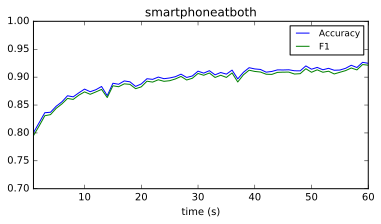

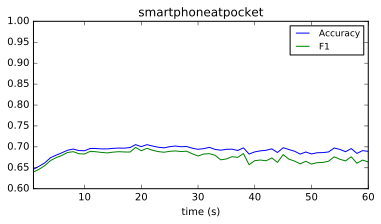

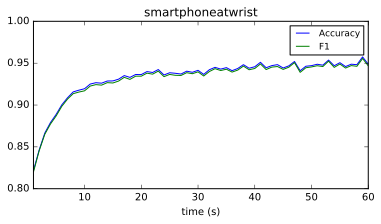

In [38]:
%pylab inline
set_matplotlib_formats('pdf', 'svg')
pylab.rcParams['figure.figsize'] = (6, 3)

results = pd.read_csv('results/classicalml_wlen.txt')
lims = {'smartphoneatwrist' : (0.8, 1),
        'smartphoneatpocket' : (0.6, 1),
        'smartphoneatboth' : (0.7, 1)}
results = results[['mode', 'window_length', 'accuracy', 'f1']]
results_by_mode = results.groupby('mode')
for (mode, group) in results_by_mode:
    results_by_w = group.groupby('window_length').agg(['mean'])
    ax = results_by_w.plot.line(x=np.arange(1,61))
    ax.set_title('{}'.format(mode))
    ax.set_xlabel('time (s)')
    ax.set_ylim(lims[mode])
    ax.legend(labels=['Accuracy','F1'], prop={'size': 9})
    #ax.get_figure().savefig('wlen_{}.eps'.format(mode))

#### Plotting the confusion matrix
The confusion matrix will allow us to know which errors are most frequent during classification. In this case, we can see that most errors involve recognizing "talking" as "standing", which seems to be a reasonable mistake.

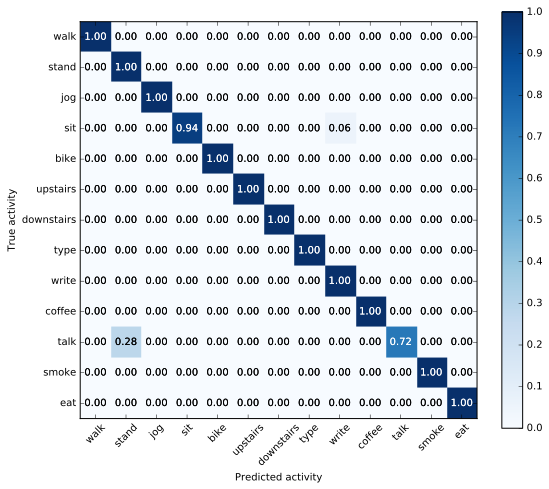

In [95]:
pylab.rcParams['figure.figsize'] = (8, 8)

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    xlocs, xlabels = plt.xticks()
    ylocs, ylabels = plt.yticks()
    plt.setp(xlabels, color='black', rotation=45)
    plt.setp(ylabels, color='black')
    plt.tight_layout()
    plt.ylabel('True activity', color='black')
    plt.xlabel('Predicted activity', color='black')
    plt.subplots_adjust(bottom=0.25)
    for (j,i),label in np.ndenumerate(cm):
        if label > 0.7:
            color = 'white'
        else:
            color = 'black'
        plt.text(i,j,'{:.2f}'.format(label),ha='center',va='center', color=color)
        plt.text(i,j,'{:.2f}'.format(label),ha='center',va='center', color=color)
    #plt.savefig('confmat.eps')

results = pd.read_csv('results/classicalml_wlen.txt')
best = results[results['accuracy'] == results.max()['accuracy']].tail(n=1)

X_train, y_train, X_test, y_test = final_datasets['smartphoneatwrist']
rseed = int(best.reset_index().get_value(0,'rseed'))
clf = sklearn.ensemble.ExtraTreesClassifier(n_estimators=20, max_depth=30, random_state = rseed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
cm = (cm * 1.0) / np.sum(cm, axis=-1)
plot_confusion_matrix(cm, acts.values())